# Investigating The Efficacy of Data Profiles in the Prediction of Pulsar Star Class.

## Introduction

A pulsar star is a neutron star with a high mass that emits electromagnetic radiation when it collapses. This emission of radiation can be detected as radio waves by telescopes thus giving them a unique integrated pulse profile and DM-SNR curve. These profiles can be used to classify a signal as either pulsar or non-pulsar. Though traditional pulsar search algorithms can identify periodic signals to be inspected by human experts, they are not adept at telling the difference between astronomical sources of periodic signal, like pulsars, and Radio Frequency Interference, or RFI, that is produced by such things as FM radio (Debesai, Gutierrez and Koyluoglu, 2020, p. 1). In this project we will be examining the use of classification towards identifying whether a given star with the necessary data is pulsar or not.


## The Dataset

To do so, we will be using the Pulsar Star Data set (available at https://archive.ics.uci.edu/ml/datasets/HTRU2). This dataset represents a collection of observed radio emissions that have been confirmed to be either from pulsar stars, or a mix of radio frequency interference (RFI) and noise. The data set shared here contains 16,259 spurious examples caused by RFI/noise, and 1,639 real pulsar examples (Lyon, Stappers, Cooper, Brooke and Knowles, 2016). Each observation contains a mean, standard deviation, kurtosis, and skewness of emissions averaged over multiple rotations of the potential pulsar star. This makes up the integrated profile (IP). Each observation also contains a transformed mean, standard deviation, kurtosis, and skewness of the emissions based on the dispersion measure (DM) to maximize the signal-to-noise ratio. This makes up the DM-SNR variables. 

## Main Question

Which data profile - the integrated pulse profile, the DM-SNR curve, or both profiles together better predicts whether a star is a pulsar? 

## Methods & Results:

### Step 1, Loading packages: 

We are first loading packages tidyverse and tidymodels to create the classification model needed to answer our main question, and repr is loaded to help view our figures.

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

### Step 2, Reading the data: 

Here, we read the dataset from the web into R and loaded the dataset to examine it (Table 1).

In [2]:
#Reading the data: Here, we read the dataset from the web into R, 
# and loaded the dataset to examine it.
options(repr.matrix.max.rows = 6)
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00372/HTRU2.zip"
download.file(url, "HTRU2.zip") 
unzip("HTRU2.zip")
pulsar_data_raw <- read_csv('HTRU_2.csv') 
pulsar_data_raw

Rows: 17897 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): 140.5625, 55.68378214, -0.234571412, -0.699648398, 3.199832776, 19....

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


140.5625,55.68378214,-0.234571412,-0.699648398,3.199832776,19.11042633,7.975531794,74.24222492,0
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
102.5078,58.88243,0.46531815,-0.5150879,1.677258,14.86015,10.576487,127.39358,0
103.0156,39.34165,0.32332837,1.0511644,3.121237,21.74467,7.735822,63.17191,0
136.7500,57.17845,-0.06841464,-0.6362384,3.642977,20.95928,6.896499,53.59366,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
119.3359,59.93594,0.1593631,-0.74302540,21.430602,58.87200,2.499517,4.595173,0
114.5078,53.90240,0.2011614,-0.02478884,1.946488,13.38173,10.007967,134.238910,0
57.0625,85.79734,1.4063910,0.08951971,188.306020,64.71256,-1.597527,1.429475,0


Table 1: Raw HTRU2 Dataset

### Step 3, Tidying and preparing the data:

Here, we tidied and wrangled the data set using these steps: 

    a) Giving names to columns 

    b) Changing the “Class” column to a factor, and setting 0 and 1 outcomes for the class variable as “No” and “Yes”, respectively, to represent negative and positive pulsar star observations, respectively.

    c) Splitting the data into the IP, DM-SNR and IP + DM-SNR profiles

        i) Group 1: Integrated profile (Table 2) 
            - Columns Mean_IP, Stdev_IP, Kurtosis_IP and Skewness_IP will be used to predict column Class
        ii) Group 2: DM-SNR profile (Table 3)
            - Columns Mean_DM, Stdev_DM, Kurtosis_DM and Skewness_DM will be used to predict column Class
        iii) Group 3: Integrated and DM-SNR profiles (Table 4)
            - Columns Mean_IP, Stdev_IP, Kurtosis_IP, Skewness_IP, Mean_DM, Stdev_DM, Kurtosis_DM and Skewness_DM will be used to  predict column Class
    d) Spitting each profile into a training and test set with a 75/25 training:testing split.


In [3]:
# Here, we tidied and wrangled the data set using these steps: 

set.seed(17)

# a) Giving names to columns 
col_names <- c('Mean_IP', 'Stdev_IP', 'Kurtosis_IP', 'Skewness_IP', 
               'Mean_DM', "Stdev_DM", 'Kurtosis_DM', "Skewness_DM", "Class")
pulsar_data <- read_csv('HTRU_2.csv', col_names)

# b) Changing the Class column to a factor 
pulsar_data_wrangled <- mutate(pulsar_data, Class = as.character(Class))

# c) Splitting the data into the IP and DM-SNR profiles
pulsar_data_wrangled$Class[pulsar_data_wrangled$Class == '0'] <- "Non-pulsar"
pulsar_data_wrangled$Class[pulsar_data_wrangled$Class == '1'] <- "Pulsar"

# d) Spitting each profile into a training and test set

Rows: 17898 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): Mean_IP, Stdev_IP, Kurtosis_IP, Skewness_IP, Mean_DM, Stdev_DM, Kur...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
#IP only
set.seed(17)

pulsar_data_IP <- select(pulsar_data_wrangled, Mean_IP, Stdev_IP, Kurtosis_IP, Skewness_IP, Class)

IP_split <- initial_split(pulsar_data_IP, prop = 0.75, strata = Class)
IP_train <- training(IP_split)
IP_test <- testing(IP_split) 
IP_train

Mean_IP,Stdev_IP,Kurtosis_IP,Skewness_IP,Class
<dbl>,<dbl>,<dbl>,<dbl>,<chr>
140.5625,55.68378,-0.2345714,-0.6996484,Non-pulsar
102.5078,58.88243,0.4653182,-0.5150879,Non-pulsar
103.0156,39.34165,0.3233284,1.0511644,Non-pulsar
⋮,⋮,⋮,⋮,⋮
122.5547,49.48561,0.1279781,0.32306090,Non-pulsar
119.3359,59.93594,0.1593631,-0.74302540,Non-pulsar
57.0625,85.79734,1.4063910,0.08951971,Non-pulsar


Table 2: Wrangled Integrated Profile Data

In [5]:
#DM-SNR only
set.seed(17)

pulsar_data_DM <- select(pulsar_data_wrangled, Mean_DM, Stdev_DM, Kurtosis_DM, Skewness_DM, Class)

DM_split <- initial_split(pulsar_data_DM, prop = 0.75, strata = Class)
DM_train <- training(DM_split)
DM_test <- testing(DM_split) 
DM_train

Mean_DM,Stdev_DM,Kurtosis_DM,Skewness_DM,Class
<dbl>,<dbl>,<dbl>,<dbl>,<chr>
3.199833,19.11043,7.975532,74.24222,Non-pulsar
1.677258,14.86015,10.576487,127.39358,Non-pulsar
3.121237,21.74467,7.735822,63.17191,Non-pulsar
⋮,⋮,⋮,⋮,⋮
16.4097,44.62689,2.945244,8.297092,Non-pulsar
21.4306,58.87200,2.499517,4.595173,Non-pulsar
188.3060,64.71256,-1.597527,1.429475,Non-pulsar


Table 3: Wrangled DM-SNR Data

In [6]:
#combined test using both methods
set.seed(17)

pulsar_data_both_methods <- pulsar_data_wrangled

both_split <- initial_split(pulsar_data_both_methods, prop = 0.75, strata = Class)
both_train <- training(both_split)
both_test <- testing(both_split)
both_train

Mean_IP,Stdev_IP,Kurtosis_IP,Skewness_IP,Mean_DM,Stdev_DM,Kurtosis_DM,Skewness_DM,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
140.5625,55.68378,-0.2345714,-0.6996484,3.199833,19.11043,7.975532,74.24222,Non-pulsar
102.5078,58.88243,0.4653182,-0.5150879,1.677258,14.86015,10.576487,127.39358,Non-pulsar
103.0156,39.34165,0.3233284,1.0511644,3.121237,21.74467,7.735822,63.17191,Non-pulsar
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
122.5547,49.48561,0.1279781,0.32306090,16.4097,44.62689,2.945244,8.297092,Non-pulsar
119.3359,59.93594,0.1593631,-0.74302540,21.4306,58.87200,2.499517,4.595173,Non-pulsar
57.0625,85.79734,1.4063910,0.08951971,188.3060,64.71256,-1.597527,1.429475,Non-pulsar


Table 4: Wrangled HTRU2 Full Dataset

### Step 4, Summary table of each dataset: 

We created a table summarizing the means, standard deviations, kurtosis, and skewness of the integrated and the DM-SNR puslar profiles (Tables 5 and 6, respectively) to explore the groups of variables to be used in our classification model.

In [7]:
#We created a table of the means, standard deviations, kurtosis, 
# and skewness of the integrated and the DM-SNR puslar profiles.

IP_train_summary <- group_by(IP_train, Class) |>
    summarize(avg_mean_ip = mean(Mean_IP), avg_stdev_ip = mean(Stdev_IP), 
              avg_kurtosis_ip = mean(Kurtosis_IP), avg_skewness_ip = mean(Skewness_IP),
              count = n(), percentage = (n() / nrow(IP_train)) * 100) 
IP_train_summary



Class,avg_mean_ip,avg_stdev_ip,avg_kurtosis_ip,avg_skewness_ip,count,percentage
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
Non-pulsar,116.60244,47.34712,0.2086105,0.3774242,12201,90.896223
Pulsar,57.11326,38.71254,3.1007397,15.3914908,1222,9.103777


Table 5: Integrated Profile Summary

In [8]:
#DM-SNR summary table
DM_train_summary <- group_by(DM_train, Class) |>
    summarize(avg_mean_dm = mean(Mean_DM), avg_stdev_dm = mean(Stdev_DM), 
              avg_kurtosis_dm = mean(Kurtosis_DM), avg_skewness_dm = mean(Skewness_DM),
              count = n(), percentage = (n() / nrow(DM_train)) * 100)
DM_train_summary

Class,avg_mean_dm,avg_stdev_dm,avg_kurtosis_dm,avg_skewness_dm,count,percentage
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>
Non-pulsar,8.698819,23.25582,8.858331,113.08022,12201,90.896223
Pulsar,48.909657,56.12792,2.771125,17.29651,1222,9.103777


Table 6: DM-SNR Summary

### Step 5, Visualizing the data: 

We visualized the distributions of means, SD, kurtoses and skewness for the integrated and DM-SNR profiles to get a sense of the difference in data defining positive and negative pulsar star examples in Figure 1. We used the cowplot package to combine each individual plot into one figure. From Figure 1, we can see that there looks to be larger distance between the mean of the integrated profile for positive and negative pulsar stars, while the spread (standard deviation) of the DM-SNR pulsar stars seemed be be larger than pulsar stars in the DM-SNR profile. This figure gives us an excellent visualization of the spread of data we will be using, but it is quite hard to see differences in the variables with the naked eye.

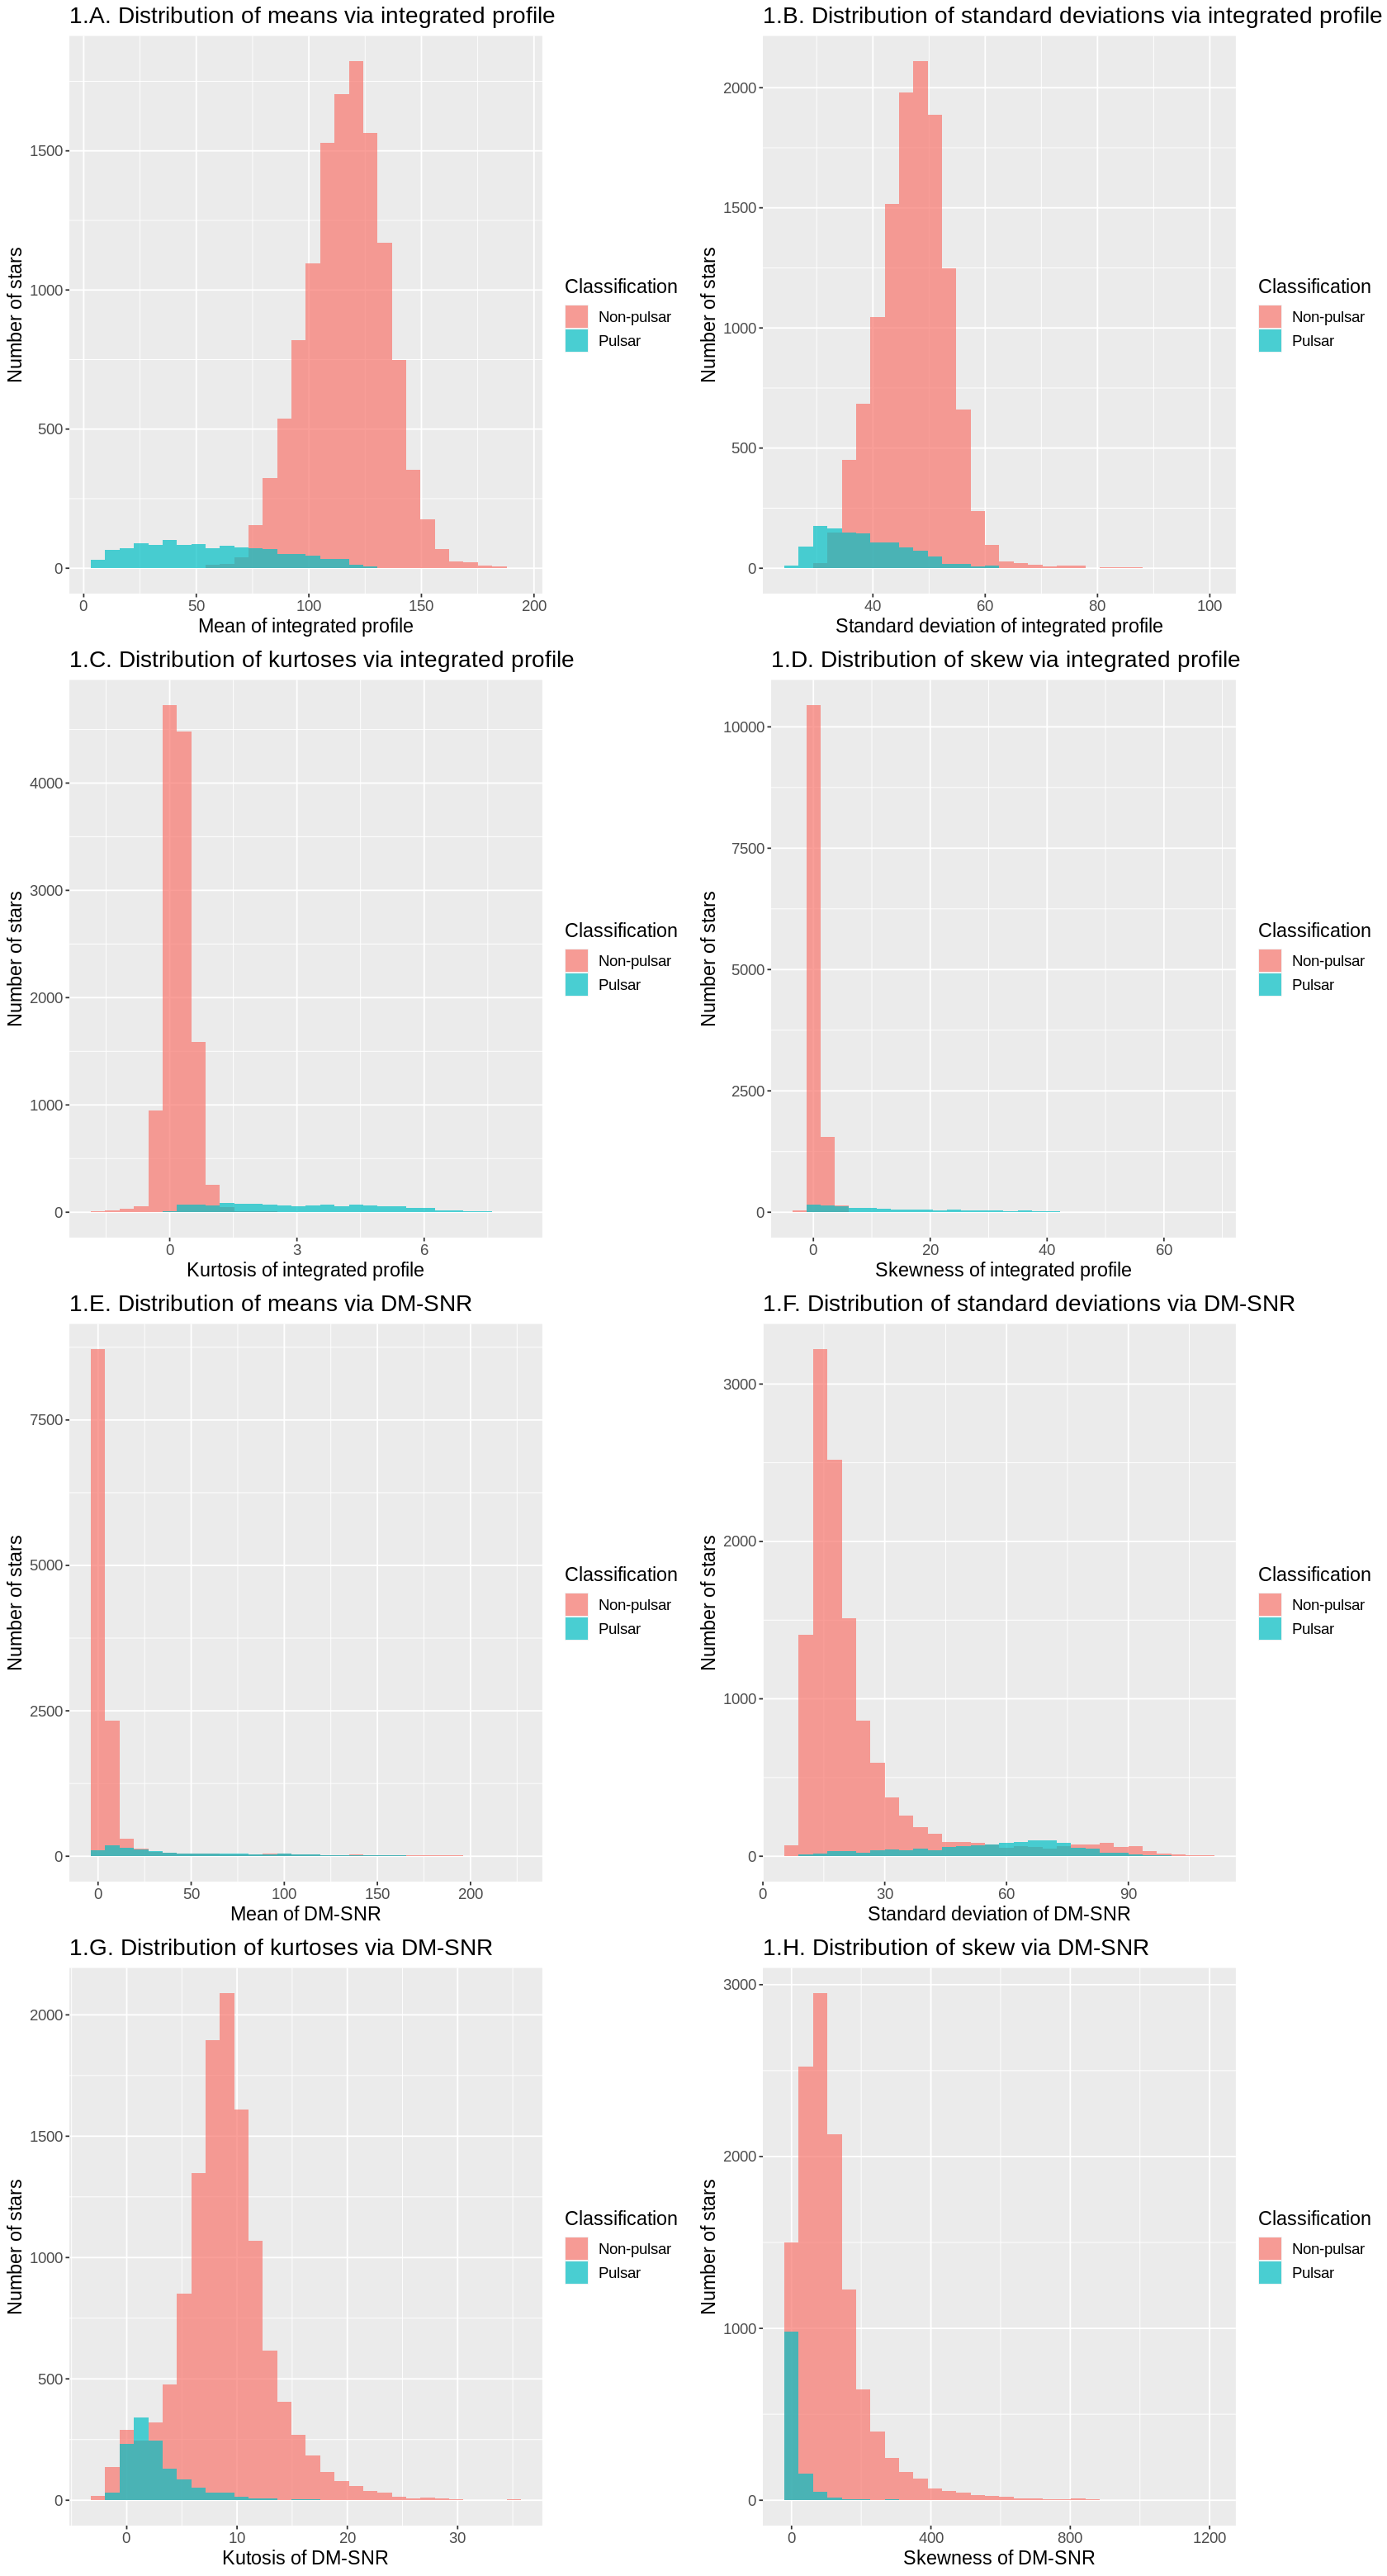

In [9]:
#We visualized the distributions of means, SD, 
# kurtoses and skewness for the integrated and DM-SNR profiles.

library(cowplot)

options(repr.plot.width = 14, repr.plot.height = 26) 

pulsar_hist_mean_IP <- ggplot(IP_train, aes(x = Mean_IP, fill = Class)) +
    geom_histogram(alpha = 0.7, position = "identity", bins = 30) +
    theme(text = element_text(size = 14)) +
    labs(x="Mean of integrated profile", 
         y= "Number of stars", 
         fill = "Classification", 
         title = '1.A. Distribution of means via integrated profile')

pulsar_hist_SD_IP <- ggplot(IP_train, aes(x = Stdev_IP, fill = Class)) +
    geom_histogram(alpha = 0.7, position = "identity", bins = 30) +
    theme(text = element_text(size = 14)) +
    labs(x="Standard deviation of integrated profile", 
         y= "Number of stars", 
         fill = "Classification", 
         title = '1.B. Distribution of standard deviations via integrated profile')

pulsar_hist_Kurtosis_IP <- ggplot(IP_train, aes(x = Kurtosis_IP, fill = Class)) +
    geom_histogram(alpha = 0.7, position = "identity", bins = 30) +
    theme(text = element_text(size = 14)) +
    labs(x="Kurtosis of integrated profile", 
         y= "Number of stars", 
         fill = "Classification", 
         title = '1.C. Distribution of kurtoses via integrated profile')

pulsar_hist_Skew_IP <- ggplot(IP_train, aes(x = Skewness_IP, fill = Class)) +
    geom_histogram(alpha = 0.7, position = "identity", bins = 30) +
    theme(text = element_text(size = 14)) +
    labs(x="Skewness of integrated profile", 
         y= "Number of stars", 
         fill = "Classification", 
         title = '1.D. Distribution of skew via integrated profile')


pulsar_hist_mean_DM <- ggplot(DM_train, aes(x = Mean_DM, fill = Class)) +
    geom_histogram(alpha = 0.7, position = "identity", bins = 30) +
    theme(text = element_text(size = 14)) +
    labs(x="Mean of DM-SNR", 
         y= "Number of stars", 
         fill = "Classification", 
         title = '1.E. Distribution of means via DM-SNR')

pulsar_hist_SD_DM <- ggplot(DM_train, aes(x = Stdev_DM, fill = Class)) +
    geom_histogram(alpha = 0.7, position = "identity", bins = 30) +
    theme(text = element_text(size = 14)) +
    labs(x="Standard deviation of DM-SNR", 
         y= "Number of stars", 
         fill = "Classification", 
         title = '1.F. Distribution of standard deviations via DM-SNR')

pulsar_hist_Kurtosis_DM <- ggplot(DM_train, aes(x = Kurtosis_DM, fill = Class)) +
    geom_histogram(alpha = 0.7, position = "identity", bins = 30) +
    theme(text = element_text(size = 14)) +
    labs(x="Kutosis of DM-SNR", 
         y= "Number of stars", 
         fill = "Classification", 
         title = '1.G. Distribution of kurtoses via DM-SNR')

pulsar_hist_Skew_DM <- ggplot(DM_train, aes(x = Skewness_DM, fill = Class)) +
    geom_histogram(alpha = 0.7, position = "identity", bins = 30) +
    theme(text = element_text(size = 14)) +
    labs(x="Skewness of DM-SNR", 
         y= "Number of stars", 
         fill = "Classification", 
         title = '1.H. Distribution of skew via DM-SNR')

Figure1_distribution_of_means <- plot_grid(pulsar_hist_mean_IP, pulsar_hist_SD_IP, 
          pulsar_hist_Kurtosis_IP, pulsar_hist_Skew_IP,
          pulsar_hist_mean_DM, pulsar_hist_SD_DM, 
          pulsar_hist_Kurtosis_DM, pulsar_hist_Skew_DM,
          ncol=2)
Figure1_distribution_of_means

Figure 1: Distribution of Predictor Means 

### Step 6, Normal distributions of average means of each profile: 

Thus, we wanted to characterize the curve of the average mean of the integrated pulse profile, and the DM-SNR profile for positive and negative pulsar stars. This could allow us to more clearly see if there is a greater difference between positive and negative pulsar stars in either profile so that we could hypothesize which one would more accurately predict the class of a pulsar star. Again, in Figure 2 we are seeing more clearly a larger distance between the means of pulsar and non-pulsars in the IP profile, while the peak density of pulsars is much lower and the distribution is wider for the DM-SMR profile. Non-pulsars have a lower peak density in the IP profile, and a less widespread distribution in the DM-SNR profile.

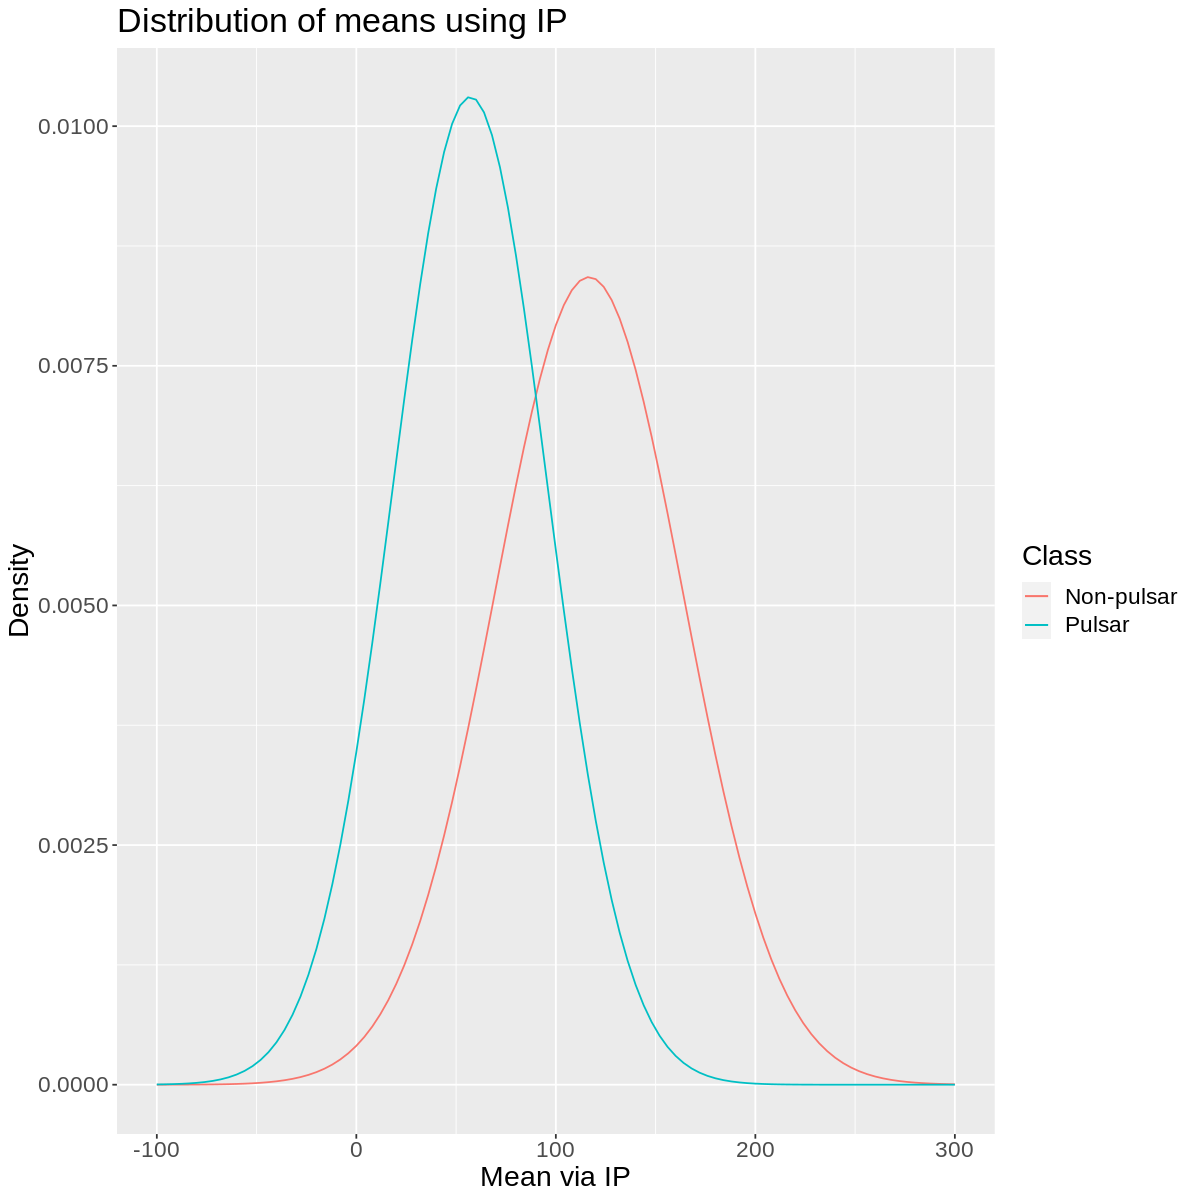

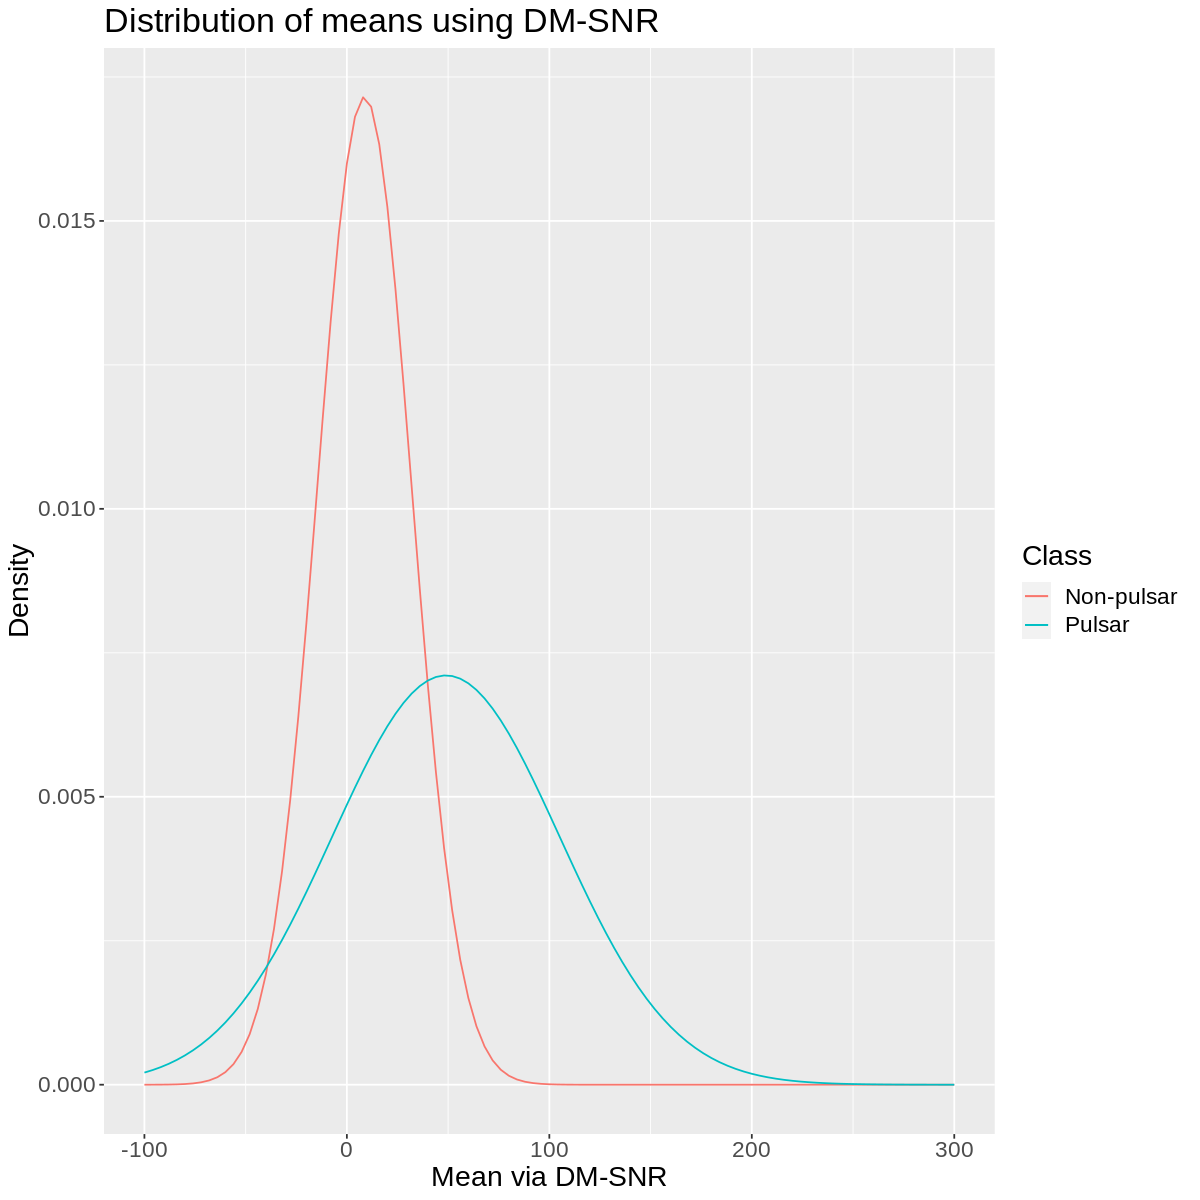

In [10]:
#We visualized the curve of the average mean of the integrated pulse profile, 
# and the DM-SNR profile for positive and negative pulsar stars.
options(repr.plot.width = 10, repr.plot.height = 10) 

IP_distribution <- ggplot() + 
  lapply(split(IP_train_summary, seq_len(nrow(IP_train_summary))), 
         \(x) stat_function(fun = dnorm, 
                            args = list(mean = x$avg_mean_ip, sd = x$avg_stdev_ip), 
                            aes(color = factor(x$Class)))) +
  theme(text = element_text(size = 17)) +
  xlim(-100,300)+
    labs(x = 'Mean via IP', y = 'Density', color = 'Class', 
         title = 'Distribution of means using IP')
IP_distribution

DM_distribution <- ggplot() + 
  lapply(split(DM_train_summary, seq_len(nrow(DM_train_summary))), 
         \(x) stat_function(fun = dnorm, 
                            args = list(mean = x$avg_mean_dm, sd = x$avg_stdev_dm), 
                            aes(color = factor(x$Class)))) +
  theme(text = element_text(size = 17)) +
  xlim(-100,300)+
    labs(x = 'Mean via DM-SNR', y = 'Density', color = 'Class', 
         title = 'Distribution of means using DM-SNR')
DM_distribution 

Figure 2: Distribution of Means for Integrated and DM-SNR Profiles

### Step 7, generating a hypothesis:  

To make a hypothesis on which profile is better at predicting pulsar star class with more confidence, we computed if the difference in means between pulsar and non-pulsar stars is significant for both profiles, taking into account the standard deviation of each profile as well.

In [11]:
set.seed(17)

integrated_pulsar <- rnorm(1639, mean = 56.69061, sd = 38.71060)
integrated_non_pulsar <- rnorm(16259, mean= 116.56273, sd = 47.33974)

integrated_profile_t_test_result <- t.test(integrated_non_pulsar, integrated_pulsar, alternative = "two.sided", var.equal = TRUE)
integrated_profile_t_test_result

DM_pulsar <- rnorm(1639, mean = 8.863258, sd = 23.28798)
DM_non_pulsar <- rnorm(16259, mean= 49.825995, sd = 56.46896)

DM_profile_t_test_result <- t.test(DM_non_pulsar, DM_pulsar, alternative = "two.sided", var.equal = TRUE)
DM_profile_t_test_result


	Two Sample t-test

data:  integrated_non_pulsar and integrated_pulsar
t = 50.286, df = 17896, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 58.27800 63.00555
sample estimates:
mean of x mean of y 
117.39165  56.74988 



	Two Sample t-test

data:  DM_non_pulsar and DM_pulsar
t = 29.697, df = 17896, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 38.94408 44.44818
sample estimates:
mean of x mean of y 
49.614483  7.918356 


#### Hypothesis:

Although both profiles are effective at telling a pulsar and non-pulsar star apart (p < 0.05), the integrated profile has a larger difference between the mean of pulsar and non-pulsar (larger t).

Thus, we hypothesize that using the integrated profile versus the DM-SNR profile will provide the most useful predictions of pulsar star class. Alternatively, using both profiles together may be most useful in determining pulsar star class, as they each provided different distribution characteristics for positive and negative examples.


### Step 8, Performing KNN classification on the integrated profile data: 

We selected to use KNN classification as we needed a quick and accurate method of categorizing unknown stars as either pulsar or non-pulsar. Because we saw in Figure 1 that the distributions of the predictors differ between each class, and we aren’t making predictions beyond the range of this dataset, we thought KNN was a suitable approach for this problem. 

We selected the integrated and DM-SNR profiles to predict pulsar star class because they have previously been used in such predictions. However, it is unknown whether the integrated profile, DM-SNR profile, or both profiles together provide better predictions of pulsar star class. Our reasoning is that all variables in each profile (kurtosis, mean, SD and skewness) are all inter-related as part of the curve each profile the star emits, so would likely be best used in groups of 4. If we had more time and resources we would also have liked to explore the kurtosis, mean, SD and skewness of each profile separately to gain a better picture of their accuracy as predictors, but we decided to focus on grouping these features into profiles to keep our project more doable.

    a) First, we created Table 7 to visualize the proportion of non-pulsar and pulsar stars in the dataset.

In [12]:
IP_proportions <- IP_train |>
    group_by(Class) |>
    summarize(n = n()) |>
    mutate(percent = 100*n/nrow(IP_train))

IP_proportions

Class,n,percent
<chr>,<int>,<dbl>
Non-pulsar,12201,90.896223
Pulsar,1222,9.103777


Table 7: Proportions of Pulsar and Non-pulsar Stars in the Integrated Profile Data

There are many more non-pulsar stars (91%) than pulsar stars (9%).

    b) Undersampling: 
    
    Therefore, we undersampled the non-pulsar stars using the themis package so that proportions of each class were equal, which can be seen in Table 8. We also tried oversampling the pulsar stars, but undersampling offered better quality data.

In [13]:
install.packages("themis") #needed for undersample
library (themis) #needed for undersample

also installing the dependencies ‘RANN’, ‘ROSE’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [14]:
#Undersampling the non-pulsar stars so that proportions of each class is equal
#Also tried oversampling the pulsar stars, but undersampling offered better quality data
set.seed(17)

IP_undersample_recipe <- recipe(Class ~ ., data = IP_train) |>
    step_nearmiss(Class, under_ratio = 1) |>  
    prep()

undersampled_IP_train <- bake(IP_undersample_recipe, new_data = NULL)

#to confirm that the data is now 50/50 for each class
undersampled_IP_proportions <- undersampled_IP_train |>
    group_by(Class) |>
    summarize(n = n()) |>
    mutate(percent = 100*n/nrow(undersampled_IP_train))

undersampled_IP_proportions

Class,n,percent
<fct>,<int>,<dbl>
Non-pulsar,1222,50
Pulsar,1222,50


Table 8: Proportions of Pulsar and Non-pulsar Stars in the Undersampled Integrated Profile Data

    c) Training the classifier and picking a range of K-values via 5-fold cross validation: 
    
    Next, we performed knn-classification on the undersampled IP training data with 5-fold cross-validation to pick K. We started by testing a wide range of K values to find a range of optimal accuracy for the classifier (Table 9 and Figure 3) to reduce the run-time of the code.

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
21,accuracy,binary,0.9267598,5,0.005415143,Preprocessor1_Model05
26,accuracy,binary,0.9259435,5,0.005295173,Preprocessor1_Model06
16,accuracy,binary,0.9259418,5,0.006814524,Preprocessor1_Model04
⋮,⋮,⋮,⋮,⋮,⋮,⋮
76,accuracy,binary,0.9161258,5,0.006148886,Preprocessor1_Model16
81,accuracy,binary,0.9148980,5,0.006595868,Preprocessor1_Model17
1,accuracy,binary,0.8858414,5,0.002382325,Preprocessor1_Model01


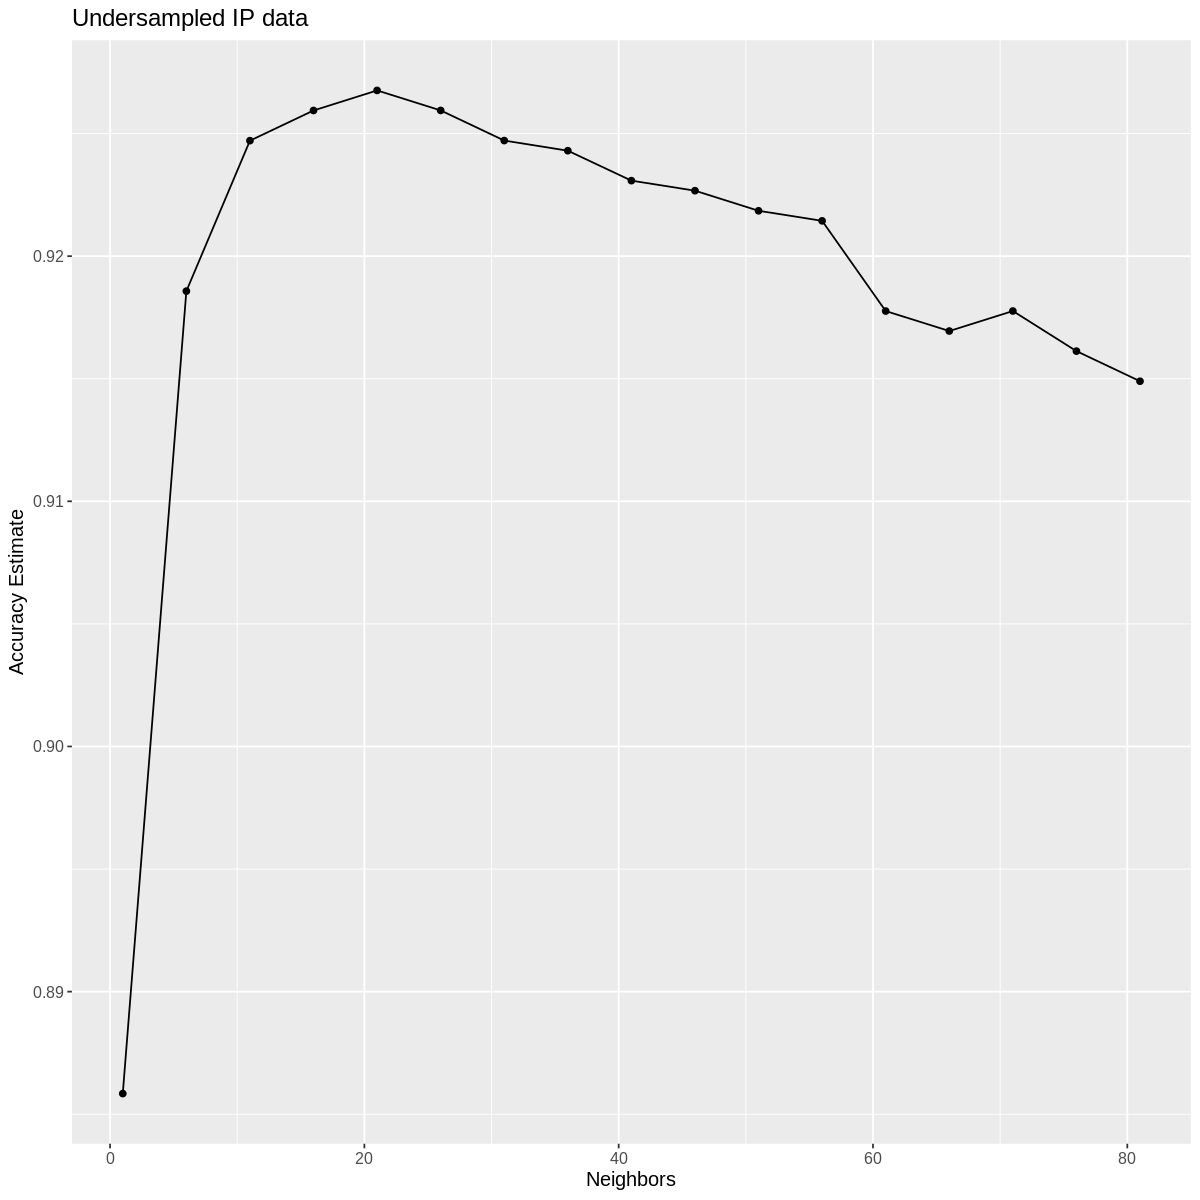

In [15]:
#knn on undersampled IP training data with 5-fold cross-validation to pick K
#starting with a wide range of K values and will narrow down after to reduce run-time 

set.seed(17)

unders_IP_recipe <- recipe(Class ~ ., data = undersampled_IP_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) 

IP_spec_train <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

unders_IP_vfold <- vfold_cv(undersampled_IP_train, v = 5, strata = Class)

k_vals <- tibble(neighbors = seq(from = 1, to = 81, by = 5)) 

unders_knn_fit <- workflow() |>
    add_recipe(unders_IP_recipe) |>
    add_model(IP_spec_train) |>
    tune_grid(resamples = unders_IP_vfold, grid = k_vals) |>
    collect_metrics() |>
    filter(.metric == "accuracy") |>
    arrange(desc(mean))
unders_knn_fit

accuracy_vs_k <- ggplot(unders_knn_fit, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(title = "Undersampled IP data", x = "Neighbors", y = "Accuracy Estimate") + 
    theme(text = element_text(size = 12))
accuracy_vs_k

Table 9: Integrated Profile Workflow Metrics Using a Broad Range of K-values

Figure 3: Accuracy Estimate by K-value (Broad Range) - Integrated Profile Data

    d) Picking the best K: 
    
    Next, we tested a narrower range of K-values to find the optimal K (Table 10 and Figure 4). The optimal K-value can be seen as K= 21 from Figure 3 (we chose because 21 over 22 because it's closer to the other peak at 17-18), with an accuracy of 92%.

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
21,accuracy,binary,0.9267598,5,0.005415143,Preprocessor1_Model06
22,accuracy,binary,0.9267598,5,0.005415143,Preprocessor1_Model07
17,accuracy,binary,0.9263483,5,0.006621810,Preprocessor1_Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
16,accuracy,binary,0.9259418,5,0.006814524,Preprocessor1_Model01
19,accuracy,binary,0.9259418,5,0.006368591,Preprocessor1_Model04
20,accuracy,binary,0.9259418,5,0.006368591,Preprocessor1_Model05


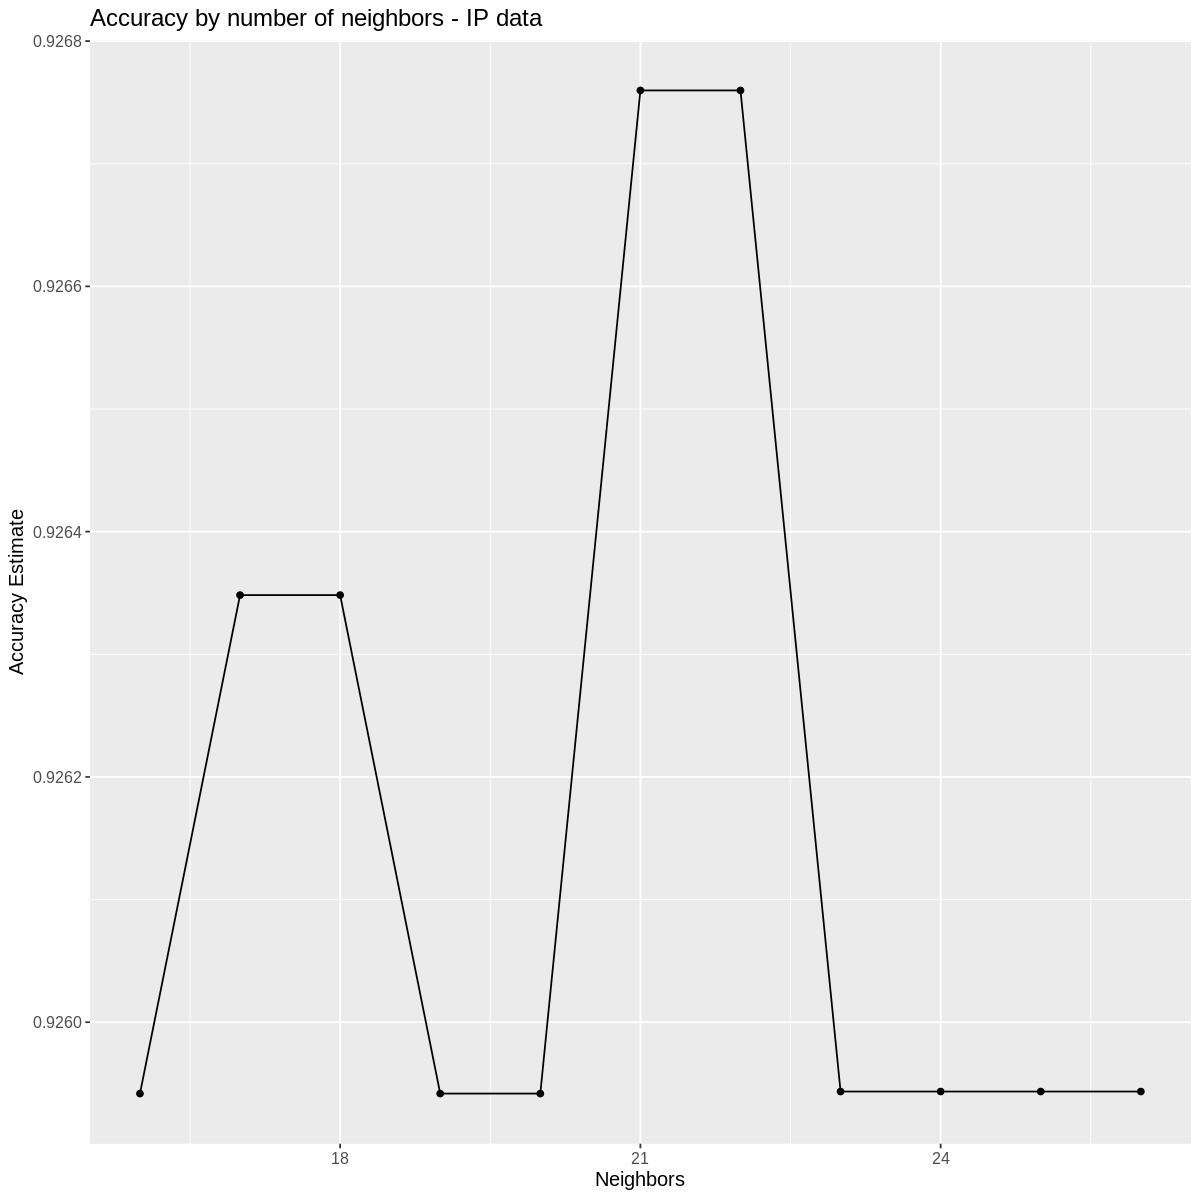

In [16]:
#Check smaller range of K-values around the peak to find single best
set.seed(17)

precise_k_vals_IP <- tibble(neighbors = seq(from = 16, to = 26, by = 1)) 

precise_knn_fit_IP <- workflow() |>
    add_recipe(unders_IP_recipe) |>
    add_model(IP_spec_train) |>
    tune_grid(resamples = unders_IP_vfold, grid = precise_k_vals_IP) |>
    collect_metrics() |>
    filter(.metric == "accuracy") |>
    arrange(desc(mean))
precise_knn_fit_IP

accuracy_vs_k <- ggplot(precise_knn_fit_IP, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(title = "Accuracy by number of neighbors - IP data", x = "Neighbors", y = "Accuracy Estimate") + 
  theme(text = element_text(size = 12))
accuracy_vs_k

Table 10: Integrated Profile Workflow Metrics Using a Precise Range of K-values

Figure 4: Accuracy Estimate by K-value (Precise Range) - Integrated Profile Data

    e) Setting up optimal parameters and checking the model against the test data: 
    
    Lastly, we specified neighbors = 21 in our KNN-classification recipe to reflect our prior work, and added our recipe, model and training data to train our classifier. We then checked the accuracy of our model against the testing data, seen in Table 11.

In [17]:
#Using best K to make the IP model
#Chose 21 over 22 because it's closer to the other peak at 17-18
set.seed(17)

IP_spec_test <- nearest_neighbor(weight_func = "rectangular", neighbors = 21) |>
    set_engine("kknn") |>
    set_mode("classification")

IP_fit_test <- workflow() |> 
    add_recipe(unders_IP_recipe) |> 
    add_model(IP_spec_test) |>
    fit(data = undersampled_IP_train)

#needed to fix an error where factor levels were in the wrong order, so wouldn't calculate metrics
IP_test <- IP_test |> 
    mutate(Class = as_factor(Class))
IP_test$Class <- factor(IP_test$Class, levels=c('Non-pulsar', 'Pulsar'))

#Checking the model against the test data
IP_test_predictions <- predict(IP_fit_test, IP_test) |>  
    bind_cols(IP_test) 

IP_accuracy <- IP_test_predictions |>
    metrics(truth = Class, estimate = .pred_class) |>
    filter(.metric == "accuracy") 
IP_accuracy

IP_conf_mat <- IP_test_predictions |> 
    conf_mat(truth = Class, estimate = .pred_class)
IP_conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9671508


            Truth
Prediction   Non-pulsar Pulsar
  Non-pulsar       3956     45
  Pulsar            102    372

Table 11: Integrated Profile Confusion Matrix

The model above is 96.7% accurate (very good), but misses 10.8% of pulsars, which is less good. These values can be seen from the confusion matrix in Table 11. 

### Step 9, Performing KNN classification on the DM-SNR profile data:

Here, we will repeat substeps a - e for step 8, this time using the DM-SNR profile. We found that the optimal K was 35, with an 87% accuracy. Substep c’s results are similarly shown in Table 13 and Figure 5, while substep d’s results are shown in Table 14 and Figure 6.

In [18]:
#Undersampling the non-pulsar stars so that proportions of each class is equal
#Also tried oversampling the pulsar stars, but undersampling offered better quality data
set.seed(17)

DMSNR_undersample_recipe <- recipe(Class ~ ., data = DM_train) |>
    step_nearmiss(Class, under_ratio = 1) |>  #undersampling
    prep()

undersampled_DMSNR_train <- bake(DMSNR_undersample_recipe, new_data = NULL)

undersampled_DMSNR_proportions <- undersampled_DMSNR_train |>
    group_by(Class) |>
    summarize(n = n()) |>
    mutate(percent = 100*n/nrow(undersampled_DMSNR_train))

undersampled_DMSNR_proportions

Class,n,percent
<fct>,<int>,<dbl>
Non-pulsar,1222,50
Pulsar,1222,50


Table 12: Proportions of Pulsar and Non-pulsar Stars in the Undersampled DM-SNR Profile Data

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
21,accuracy,binary,0.8674490,5,0.008399248,Preprocessor1_Model05
26,accuracy,binary,0.8670475,5,0.010430353,Preprocessor1_Model06
61,accuracy,binary,0.8662278,5,0.010528758,Preprocessor1_Model13
⋮,⋮,⋮,⋮,⋮,⋮,⋮
11,accuracy,binary,0.8604901,5,0.007872286,Preprocessor1_Model03
6,accuracy,binary,0.8559803,5,0.005240109,Preprocessor1_Model02
1,accuracy,binary,0.8248829,5,0.007005115,Preprocessor1_Model01


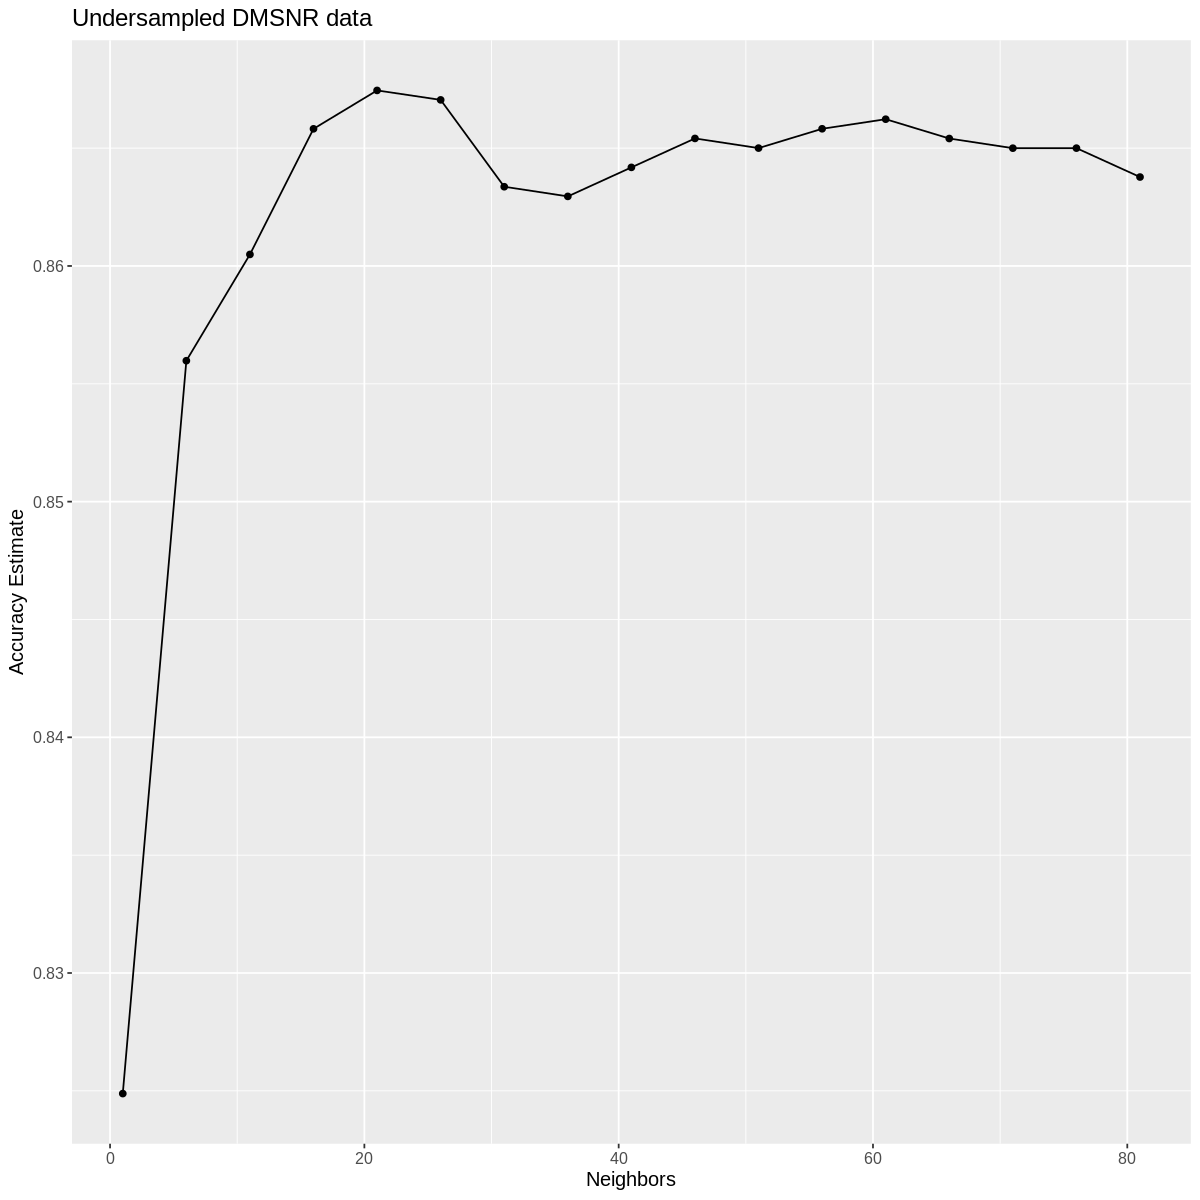

In [19]:
#knn on undersampled DMSNR training data with 5-fold cross-validation to pick K
#starting with a wide range of K values and will narrow down after to reduce run-time 
set.seed(17)

unders_DMSNR_recipe <- recipe(Class ~ ., data = undersampled_DMSNR_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) 

DMSNR_spec_train <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

unders_DMSNR_vfold <- vfold_cv(undersampled_DMSNR_train, v = 5, strata = Class)

k_vals <- tibble(neighbors = seq(from = 1, to = 81, by = 5)) 

unders_knn_fit <- workflow() |>
    add_recipe(unders_DMSNR_recipe) |>
    add_model(DMSNR_spec_train) |>
    tune_grid(resamples = unders_DMSNR_vfold, grid = k_vals) |>
    collect_metrics() |>
    filter(.metric == "accuracy") |>
    arrange(desc(mean))
unders_knn_fit

accuracy_vs_k <- ggplot(unders_knn_fit, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(title = "Undersampled DMSNR data", x = "Neighbors", y = "Accuracy Estimate") + 
    theme(text = element_text(size = 12))
accuracy_vs_k

Table 13: DM-SNR Profile Workflow Metrics Using a Broad Range of K-values

Figure 5: Accuracy Estimate by K-value (Broad Range) - DM-SNR Profile Data

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
19,accuracy,binary,0.8674523,5,0.009059155,Preprocessor1_Model04
20,accuracy,binary,0.8674523,5,0.009059155,Preprocessor1_Model05
21,accuracy,binary,0.8674490,5,0.008399248,Preprocessor1_Model06
⋮,⋮,⋮,⋮,⋮,⋮,⋮
17,accuracy,binary,0.8637722,5,0.009256631,Preprocessor1_Model02
18,accuracy,binary,0.8637722,5,0.009256631,Preprocessor1_Model03
31,accuracy,binary,0.8633623,5,0.011662369,Preprocessor1_Model16


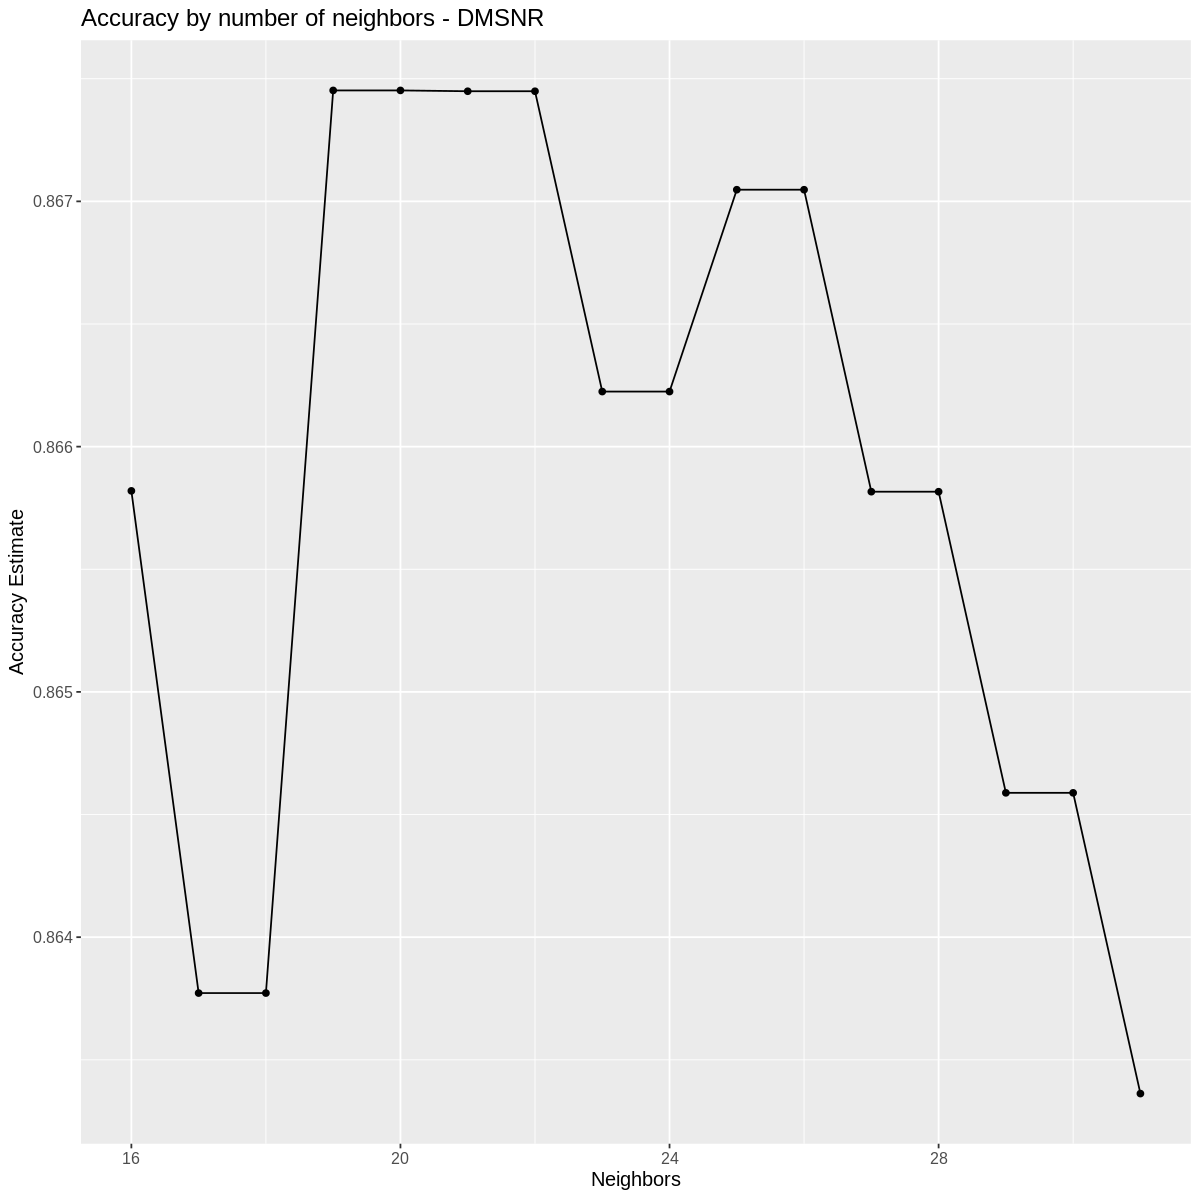

In [20]:
#Check smaller range of K-values around the peak to find single best
set.seed(17)

precise_k_vals_2 <- tibble(neighbors = seq(from = 16, to = 31, by = 1)) 

precise_knn_fit <- workflow() |>
    add_recipe(unders_DMSNR_recipe) |>
    add_model(DMSNR_spec_train) |>
    tune_grid(resamples = unders_DMSNR_vfold, grid = precise_k_vals_2) |>
    collect_metrics() |>
    filter(.metric == "accuracy") |>
    arrange(desc(mean))
precise_knn_fit

accuracy_vs_k_2 <- ggplot(precise_knn_fit, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(title = "Accuracy by number of neighbors - DMSNR", x = "Neighbors", y = "Accuracy Estimate") + 
  theme(text = element_text(size = 12))
accuracy_vs_k_2

Table 14: DM-SNR Profile Workflow Metrics Using a Precise Range of K-values

Figure 6: Accuracy Estimate by K-value (Precise Range) - DM-SNR Profile Data

In [21]:
#Using found K to make model
#Chose 20 since it's closer to the center of the peak

DMSNR_spec_test <- nearest_neighbor(weight_func = "rectangular", neighbors = 20) |>
    set_engine("kknn") |>
    set_mode("classification")

DMSNR_fit_test <- workflow() |> 
    add_recipe(unders_DMSNR_recipe) |> 
    add_model(DMSNR_spec_test) |>
    fit(data = undersampled_DMSNR_train)

#needed to fix an error where factor levels were in the wrong order, so wouldn't calculate metrics
DM_test <- DM_test |> 
    mutate(Class = as_factor(Class))
DM_test$Class <- factor(DM_test$Class, levels=c('Non-pulsar', 'Pulsar'))

DMSNR_test_predictions <- predict(DMSNR_fit_test, DM_test) |>  
    bind_cols(DM_test) 

#Checking the model against the test data
DMSNR_accuracy <- DMSNR_test_predictions |>
    metrics(truth = Class, estimate = .pred_class) |>
    filter(.metric == "accuracy") 
DMSNR_accuracy

DMSNR_conf_mat <- DMSNR_test_predictions |> 
    conf_mat(truth = Class, estimate = .pred_class)
DMSNR_conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8420112


            Truth
Prediction   Non-pulsar Pulsar
  Non-pulsar       3400     49
  Pulsar            658    368

Table 15: DM-SNR Profile Confusion Matrix

The model above is ~84.2% accurate -less good, and misses ~11.8% of pulsars - also less good, which can be seen from the confusion matrix Table 15.

### Step 10, Performing KNN classification on the Integrated + DM-SNR profile data:

Here, we will repeat substeps a - e for step 8, this time using the DM-SNR + Integrated profile. We found that the optimal K was 11, with an 94% accuracy. Substep c’s results are similarly shown in Table 17 and Figure 7, while substep d’s results are shown in Table 18 and Figure 8.

In [22]:
#Undersampling the non-pulsar stars so that proportions of each class is equal
#Also tried oversampling the pulsar stars, but undersampling offered better quality data
set.seed(17)

both_undersample_recipe <- recipe(Class ~ ., data = both_train) |>
    step_nearmiss(Class, under_ratio = 1) |> 
    prep()

undersampled_both_train <- bake(both_undersample_recipe, new_data = NULL)

undersampled_both_proportions <- undersampled_both_train |>
    group_by(Class) |>
    summarize(n = n()) |>
    mutate(percent = 100*n/nrow(undersampled_both_train))

undersampled_both_proportions

Class,n,percent
<fct>,<int>,<dbl>
Non-pulsar,1222,50
Pulsar,1222,50


Table 16: Proportions of Pulsar and Non-pulsar Stars in the Undersampled Combined Profile Data

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
11,accuracy,binary,0.9279910,5,0.005681110,Preprocessor1_Model03
6,accuracy,binary,0.9271696,5,0.005770244,Preprocessor1_Model02
21,accuracy,binary,0.9247240,5,0.007479950,Preprocessor1_Model05
⋮,⋮,⋮,⋮,⋮,⋮,⋮
81,accuracy,binary,0.9153111,5,0.007050854,Preprocessor1_Model17
76,accuracy,binary,0.9153078,5,0.006571871,Preprocessor1_Model16
1,accuracy,binary,0.8981164,5,0.008300761,Preprocessor1_Model01


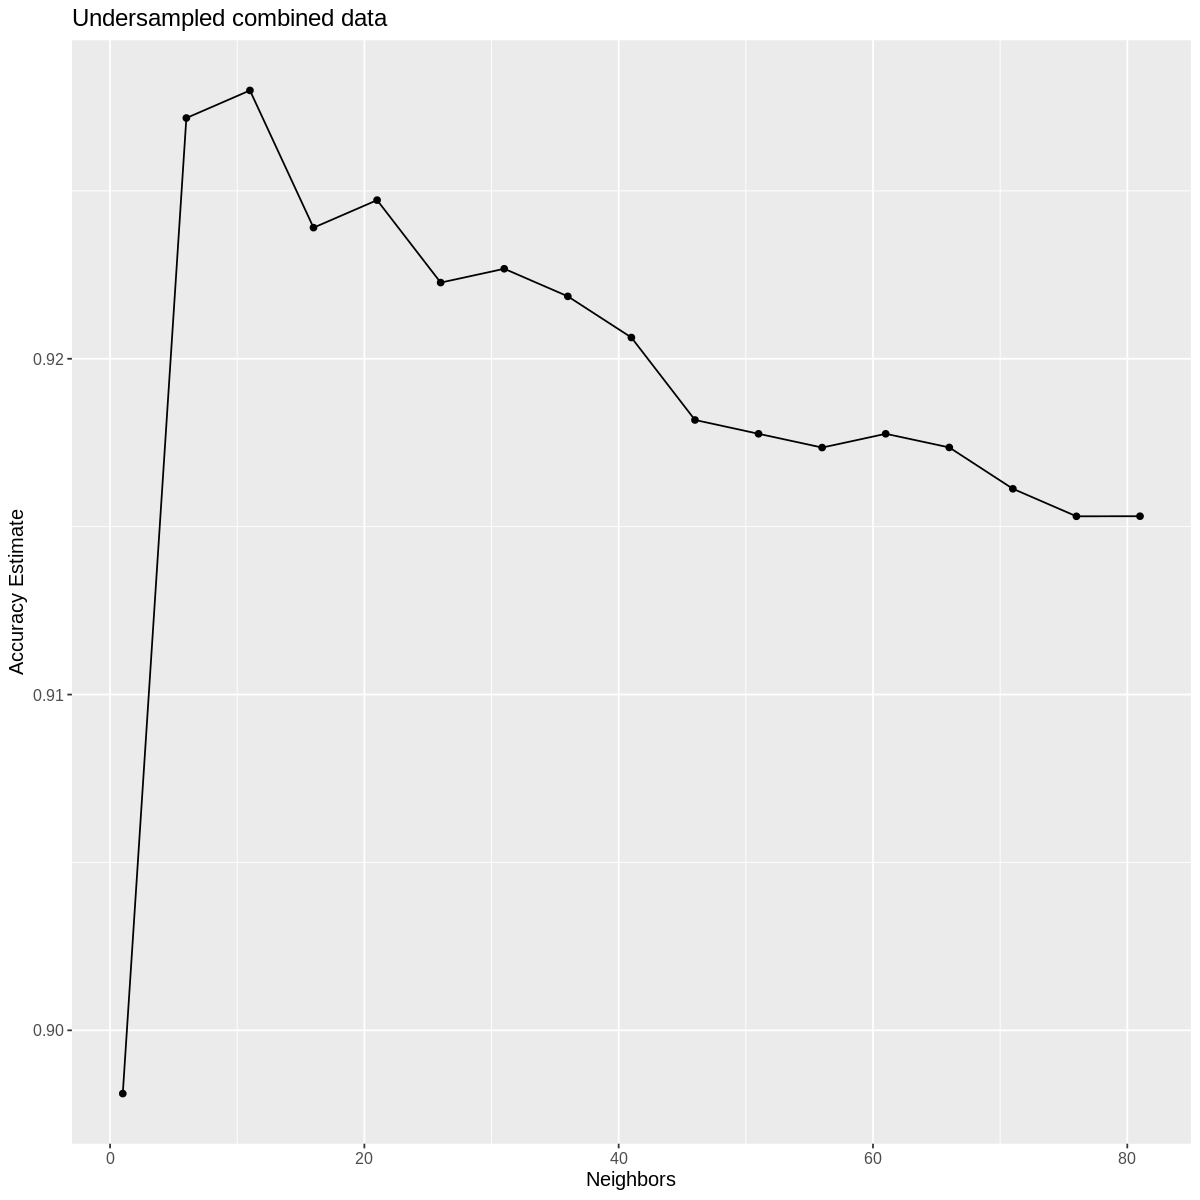

In [23]:
#knn on undersampled combined training data with 5-fold cross-validation to pick K
#starting with a wide range of K values and will narrow down after to reduce run-time 
set.seed(17)

unders_both_recipe <- recipe(Class ~ ., data = undersampled_both_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) 

both_spec_train <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

unders_both_vfold <- vfold_cv(undersampled_both_train, v = 5, strata = Class)

k_vals <- tibble(neighbors = seq(from = 1, to = 81, by = 5)) 

unders_knn_fit <- workflow() |>
    add_recipe(unders_both_recipe) |>
    add_model(both_spec_train) |>
    tune_grid(resamples = unders_both_vfold, grid = k_vals) |>
    collect_metrics() |>
    filter(.metric == "accuracy") |>
    arrange(desc(mean))
unders_knn_fit

accuracy_vs_k <- ggplot(unders_knn_fit, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(title = "Undersampled combined data", x = "Neighbors", y = "Accuracy Estimate") + 
    theme(text = element_text(size = 12))
accuracy_vs_k

Table 17: Combined Profile Workflow Metrics Using a Broad Range of K-values

Figure 7: Accuracy Estimate by K-value (Broad Range) - Combined Profile Data

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
9,accuracy,binary,0.9300318,5,0.005692658,Preprocessor1_Model04
10,accuracy,binary,0.9300318,5,0.005692658,Preprocessor1_Model05
7,accuracy,binary,0.9296219,5,0.006843124,Preprocessor1_Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
14,accuracy,binary,0.9243091,5,0.006489691,Preprocessor1_Model09
15,accuracy,binary,0.9239043,5,0.006556460,Preprocessor1_Model10
16,accuracy,binary,0.9239043,5,0.006556460,Preprocessor1_Model11


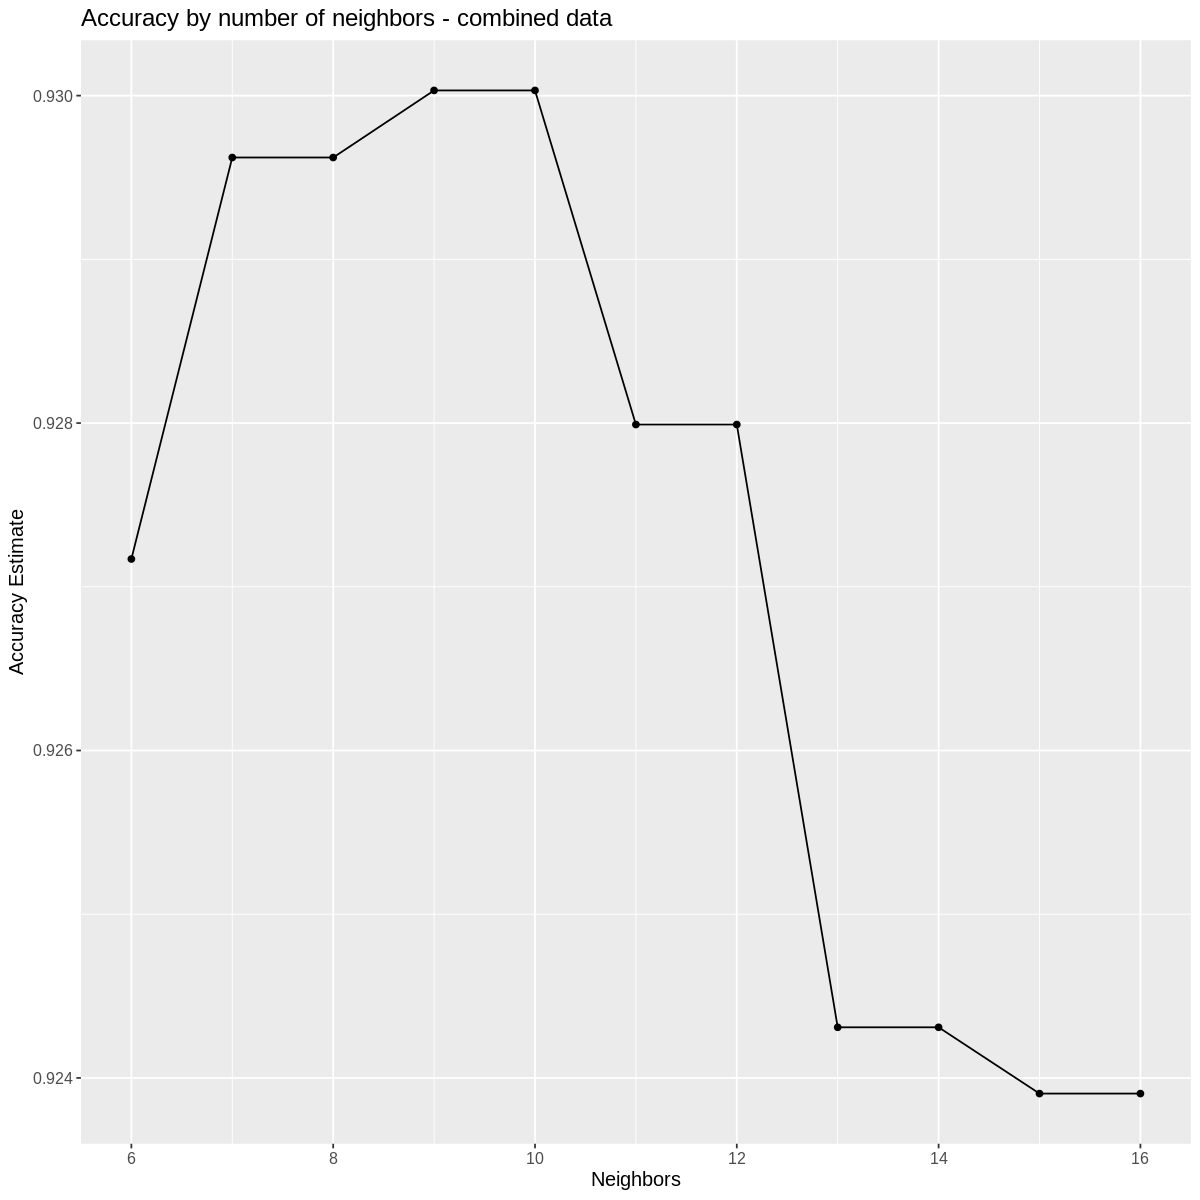

In [24]:
#Check smaller range of K-values around the peak to find single best
set.seed(17)

precise_k_vals_2 <- tibble(neighbors = seq(from = 6, to = 16, by = 1)) 

precise_knn_fit <- workflow() |>
    add_recipe(unders_both_recipe) |>
    add_model(both_spec_train) |>
    tune_grid(resamples = unders_both_vfold, grid = precise_k_vals_2) |>
    collect_metrics() |>
    filter(.metric == "accuracy") |>
    arrange(desc(mean))
precise_knn_fit

accuracy_vs_k_2 <- ggplot(precise_knn_fit, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(title = "Accuracy by number of neighbors - combined data", x = "Neighbors", y = "Accuracy Estimate") + 
  theme(text = element_text(size = 12))
accuracy_vs_k_2

Table 18: Combined Profile Workflow Metrics Using a Precise Range of K-values

Figure 8: Accuracy Estimate by K-value (Precise Range) - Combined Profile Data

In [25]:
#Using found K to make model

both_spec_test <- nearest_neighbor(weight_func = "rectangular", neighbors = 9) |>
    set_engine("kknn") |>
    set_mode("classification")

both_fit_test <- workflow() |> 
    add_recipe(unders_both_recipe) |> 
    add_model(both_spec_test) |>
    fit(data = undersampled_both_train)

#needed to fix an error where factor levels were in the wrong order, so wouldn't calculate metrics
both_test <- both_test |> 
    mutate(Class = as_factor(Class))
both_test$Class <- factor(both_test$Class, levels=c('Non-pulsar', 'Pulsar'))

both_test_predictions <- predict(both_fit_test, both_test) |>  
    bind_cols(both_test) 

#Checking the model against the test data
both_accuracy <- both_test_predictions |>
    metrics(truth = Class, estimate = .pred_class) |>
    filter(.metric == "accuracy") 
both_accuracy

both_conf_mat <- both_test_predictions |> 
    conf_mat(truth = Class, estimate = .pred_class)
both_conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.956648


            Truth
Prediction   Non-pulsar Pulsar
  Non-pulsar       3902     38
  Pulsar            156    379

Table 19: Combined Profile Confusion Matrix

Overall accuracy of ~95.7% (second best) and only misses 9.11% of pulsar stars (best), see Tabel 20.

## Discussion: 

Our findings showed that including predictors from the integrated and DM-SNR profiles together had the lowest miss rate (9.11%), and second-highest accuracy (95.7%), while the Integrated profile had the highest accuracy (96.7%) and second-lowest miss rate (10.8%). The DM-SNR profile had the lowest accuracy (84.2%) and highest miss rate (11.8%) in detecting pulsar stars. We predict that it would be better to overestimate pulsars than miss some. Thus, we expect the DM-SNR + Integrated profile is likely the best model to screen for pulsar/non, pulsar stars. 

This model could be used to filter the data to probable pulsars, and the hits could be manually checked afterwards for confirmation. Because there are only a few hundred pulsar stars for every 16,000 stars tested, this would likely not be too much additional work and could prevent scientists from missing key pulsar stars needed for research.

This was consistent with our hypothesis because it matched our predictions almost perfectly. The integrated profile was a better predictor of pulsar star class than the DM-SNR profile, and both profiles together were better than either profile alone.
Investigating which profile best predicts the class of a pulsar star can help us to better understand and identify these cosmic phenomena. Finding such phenomena and investigating them is of great significance, pulsars have been used since the 1990’s as alternatives to atom calculators because they are so accurate in the intervals that they produce magnetic fields.

Thus, this leads us to future questions such as: if a pulsar star has been identified, what is the correlation of its findings to other cosmic phenomena such as dark matter and gravity waves? Pulsars are being used by scientists to investigate the most extreme forms of matter, look for extrasolar planets, and measure cosmic distances. Pulsars may also aid in the discovery of gravitational waves, which may lead to the detection of powerful cosmic occurrences like the collisions of supermassive black holes.

## References

Cofield, C. (2016, April 22). What are pulsars? Space.com. Retrieved December 4, 2022, from https://www.space.com/32661-pulsars.html 

Debesai S., Gutierrez C., & Koyluoglu N.U. (2020). Application of machine learning methods to identify and categorize radio pulsar signal candidates.

Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

Lyon R.J., Stappers B.W., Cooper S., Brooke J.M., & Knowles J.D. (n.d). Fifty years of pulsar candidate selection: From simple filters to a new principled real-time classification approach. Monthly notices of the royal astronomical society, 459(1), 1104-1123. DOI: 10.1093/mnras/stw656 

Nm, N. (2012, February 20). Pulsars: The Universe's gift to physics. Astronomy.com. Retrieved December 4, 2022, from https://astronomy.com/news/2012/02/pulsars---the-universes-gift-to-physics 